In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [ ]:
from data_load import Data
load = Data()
load.HOMES_FOR_SALE()
load.INCOME()
load.HOMICIDES()
load.POPULATION()
load.ZIP_COUNTY()

In [2]:
from Final_Data_Output import Final_Data as FD
FD = FD()
clean_df = FD.Merge_all(min_price=10000)                
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066816 entries, 0 to 1066815
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   bed                 1066816 non-null  float64
 1   bath                1066816 non-null  float64
 2   house_size          1066816 non-null  float64
 3   acre_lot            1066816 non-null  float64
 4   zip_code            1066816 non-null  float64
 5   Household_AGI       1066816 non-null  float64
 6   Total_Pop           1066816 non-null  float64
 7   Homicides           1066816 non-null  float64
 8   bed_bath_ratio      1066816 non-null  float64
 9   economic_health     1066816 non-null  float64
 10  lot_to_house_ratio  1066816 non-null  float64
 11  log_price           1066816 non-null  float64
dtypes: float64(12)
memory usage: 97.7 MB


In [ ]:
sns.histplot(clean_df['log_price'], kde=True)
plt.show()

In [4]:
from model_testing import Testing_Models as TM
tm = TM(clean_df.drop(columns=['log_price']), clean_df['log_price'])
glmm_mod = tm.GLMM()
glmm_mod

C:\Users\ej_la\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


{'error': 0.3857567757125769,
 'variance_explained': np.float64(0.764131581436903),
 'y_pred': 42608      4.457658e+05
 382056     3.585336e+05
 1065568    4.983030e+05
 481598     6.072111e+05
 197813     2.373183e+05
                ...     
 476221     2.477933e+06
 48730      3.398637e+05
 963406     9.169204e+05
 681883     5.843831e+05
 379524     3.211870e+05
 Length: 313197, dtype: float64,
 'model': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x19c7839ecf0>,
 'scale_fit': StandardScaler()}

In [5]:
XGB_model = tm.XGBoost(gamma=0.0025, learning_rate=0.075, colsample_bytree=0.705, subsample=0.6, max_depth=10, min_child_weight=2)
XGB_model

{'error': 0.26899242453378275,
 'variance_explained': np.float64(0.885310735425273),
 'y_pred': array([ 409841.88,  317884.12,  441498.34, ..., 1158693.8 ,  666044.6 ,
         294080.  ], shape=(313197,), dtype=float32),
 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.705, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.0025, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.075, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...),
 'scale_fi

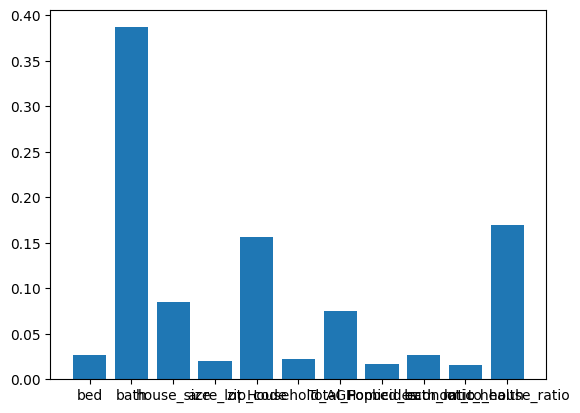

In [6]:
XGB_Features = pd.DataFrame({'Features': clean_df.drop(columns=['log_price']).columns, 'Weights': XGB_model['model'].feature_importances_})
plt.figure()
plt.bar(XGB_Features['Features'], XGB_Features['Weights'])
plt.show()

In [ ]:
RF_model = tm.Random_Forest(max_depth=30, min_samples_split=2)
RF_model

In [7]:
from Client_choice import Client_Opt as CO
client = CO(clean_df, XGB_model['model'], XGB_model['scale_fit'])
result = client.Client_prediction()
result.reset_index(inplace=True)
result.rename(columns = {'index': 'rank'}, inplace=True)

Chosen Bedrooms: 3
Chosen Bathrooms: 2
Chosen Square Footage: 1500
Chosen Square Footage: 0.25


In [ ]:
result.to_json("zip_scores.json", orient="records")

In [ ]:
result["zip_code"] = result["zip_code"].astype(int)
result["zip_code"] = result["zip_code"].astype(str)
zip_scores = {
    str(row["zip_code"]): {
        **row.drop("zip_code").to_dict(),
        "rank": int(row["rank"]),
        "Predicted_Price": float(row["Predicted_Price"]),
        "Total_Pop": int(row["Total_Pop"]),
        "Homicide_Rate": float(row["Homicide_Rate"]),
    }
    for _, row in result.iterrows()
}
json_str = json.dumps(zip_scores, indent=2)

js_str = f"const zipScores = {json_str};"
with open("zip_scores.js", "w") as f:
    f.write(js_str)
print(js_str)